In [ ]:
!unzip '/content/drive/MyDrive/File Submission/Gold_Prices.zip' -d Gold_Prices

Archive:  /content/drive/MyDrive/File Submission/Gold_Prices.zip
  inflating: Gold_Prices/XAU_15m_data.csv  
  inflating: Gold_Prices/XAU_1Month_data.csv  
  inflating: Gold_Prices/XAU_1d_data.csv  
  inflating: Gold_Prices/XAU_1h_data.csv  
  inflating: Gold_Prices/XAU_1w_data.csv  
  inflating: Gold_Prices/XAU_30m_data.csv  
  inflating: Gold_Prices/XAU_4h_data.csv  
  inflating: Gold_Prices/XAU_5m_data.csv  


1. Import Library yang di perlukan.

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import GRU, Dense

2. Load data
membaca data dari dataset yang sudah di unzip (saya mengerjakan melalui google colab)

In [ ]:
df = pd.read_csv('/content/Gold_Prices/XAU_1d_data.csv', sep=';')

* Menampikan jumlah baris dan kolom dalam dataset

In [ ]:
print("Jumlah baris dan kolom:")
print(df.shape)  # (baris, kolom)
print()

Jumlah baris dan kolom:
(5295, 6)



* Menampilkan Missing value pada dataset

In [ ]:
# Menampilkan jumlah nilai yang hilang per kolom
print(df.isnull().sum())

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


* Menampilkan jumlah data duplikat

In [ ]:
print("Jumlah duplikat:")
print(df.duplicated().sum())
print()

Jumlah duplikat:
0



* Menampilkan Outlier pada dataset

In [ ]:
print("Mendeteksi Outlier:")
def detect_outliers(df):
    outlier_info = {}
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_info[col] = outliers.shape[0]
    return outlier_info

outliers = detect_outliers(df)
for col, count in outliers.items():
    print(f"Kolom '{col}': {count} outlier")
print()

Mendeteksi Outlier:
Kolom 'Open': 2 outlier
Kolom 'High': 1 outlier
Kolom 'Low': 2 outlier
Kolom 'Close': 1 outlier
Kolom 'Volume': 82 outlier



* Visualisasi dengan Boxplot agar lebih mudah untuk melihat outlier

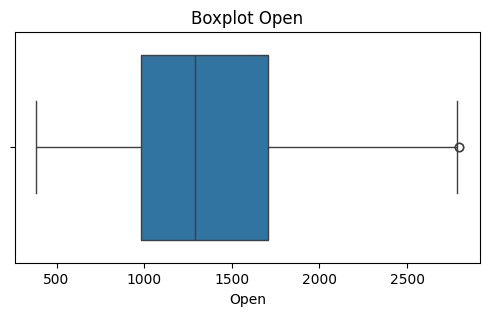

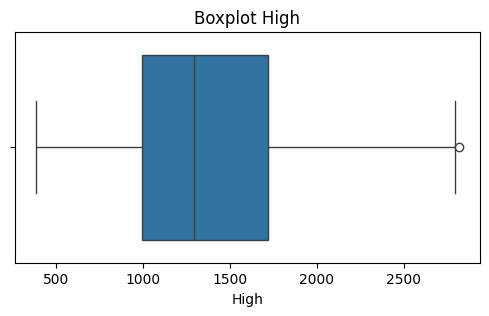

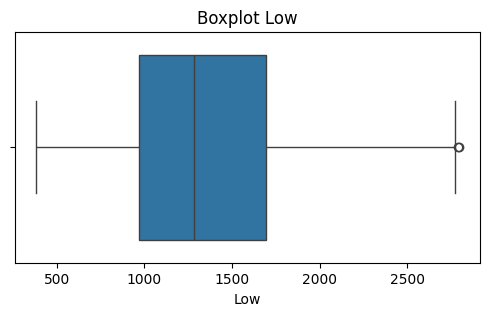

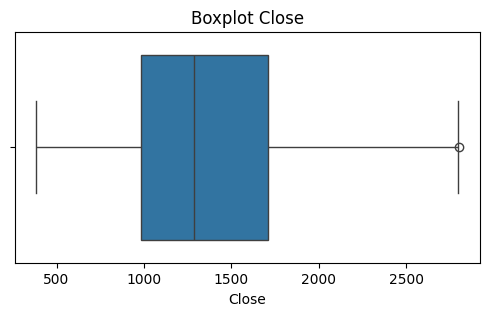

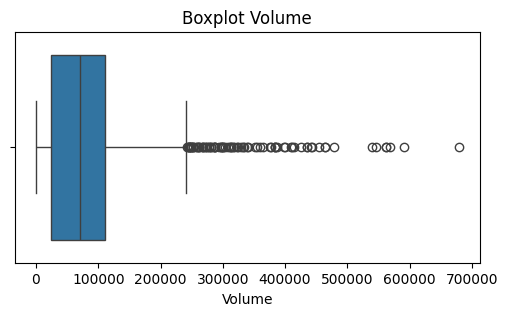

In [ ]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')
    plt.show()

* Menampilkan data oulier untuk menentukan langkah terbaik dalam menangani setiap outlier.

In [ ]:
def detect_outliers(df, column):
    # Menghitung IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Menentukan batas bawah dan atas untuk mendeteksi outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Menemukan outlier
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return outliers

# Menampilkan outlier untuk setiap kolom
columns_to_check = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in columns_to_check:
    print(f"Outliers detected in column: {col}")
    outliers = detect_outliers(df, col)
    if not outliers.empty:
        print(outliers)
    else:
        print("No outliers detected.\n")

Outliers detected in column: Open
                  Date     Open     High      Low    Close  Volume
5293  2025.01.31 00:00  2795.08  2817.23  2791.02  2799.23   91164
5294  2025.02.03 00:00  2794.53  2795.01  2794.21  2794.41    1631
Outliers detected in column: High
                  Date     Open     High      Low    Close  Volume
5293  2025.01.31 00:00  2795.08  2817.23  2791.02  2799.23   91164
Outliers detected in column: Low
                  Date     Open     High      Low    Close  Volume
5293  2025.01.31 00:00  2795.08  2817.23  2791.02  2799.23   91164
5294  2025.02.03 00:00  2794.53  2795.01  2794.21  2794.41    1631
Outliers detected in column: Close
                  Date     Open     High      Low    Close  Volume
5293  2025.01.31 00:00  2795.08  2817.23  2791.02  2799.23   91164
Outliers detected in column: Volume
                  Date     Open     High      Low    Close  Volume
2219  2013.02.20 00:00  1604.55  1609.53  1558.65  1563.94  260439
2220  2013.02.21 00:00  

3. Exploratory data.

Grafik ini membantu untuk melihat pola atau tren harga emas selama 20 tahun (naik, turun, volatilitas). Terlihat dari grafik data dominan naik, harga emas memperlihatkan naik di setiap tahunnya meskipun sempat mengalami penurunan di beberapa periode.

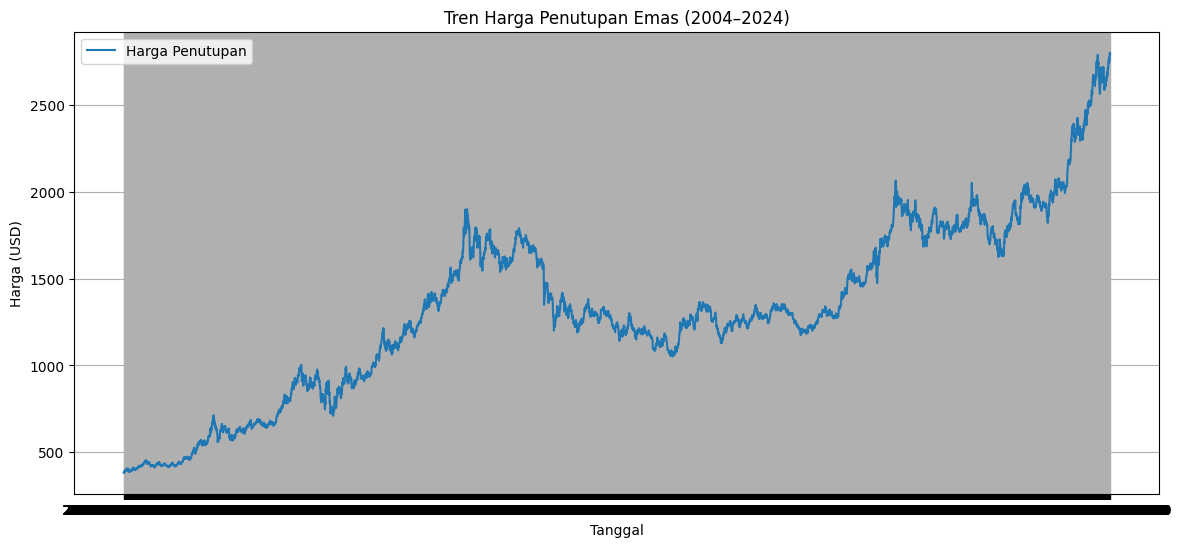

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Harga Penutupan')
plt.title('Tren Harga Penutupan Emas (2004–2024)')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True)
plt.show()

Moving Average (MA) membantu menghaluskan fluktuasi harian sehingga tren besar lebih terlihat jelas.
Grafik di bawah menunjukkan tren harga penutupan emas dari tahun 2004 hingga 2024, beserta dua garis Moving Average, yaitu MA 50 Hari dan MA 200 Hari.
Dari grafik tersebut dapat dilihat beberapa hal penting:

* Harga emas secara keseluruhan mengalami kenaikan signifikan dalam periode 20 tahun ini, meskipun terdapat beberapa fase koreksi atau penurunan harga sementara.

* Garis MA 50 Hari (oranye) lebih responsif terhadap perubahan harga jangka pendek dibandingkan MA 200 Hari (hijau), yang lebih halus dan merepresentasikan tren jangka panjang.

* Ketika MA 50 Hari berada di atas MA 200 Hari, ini biasanya menandakan tren naik (bullish trend).

* Sebaliknya, ketika MA 50 Hari memotong turun di bawah MA 200 Hari, ini bisa mengindikasikan tren turun (bearish trend).

* Moving Averages berfungsi untuk mengurangi noise dari data harga harian dan membantu mengidentifikasi arah tren lebih jelas.


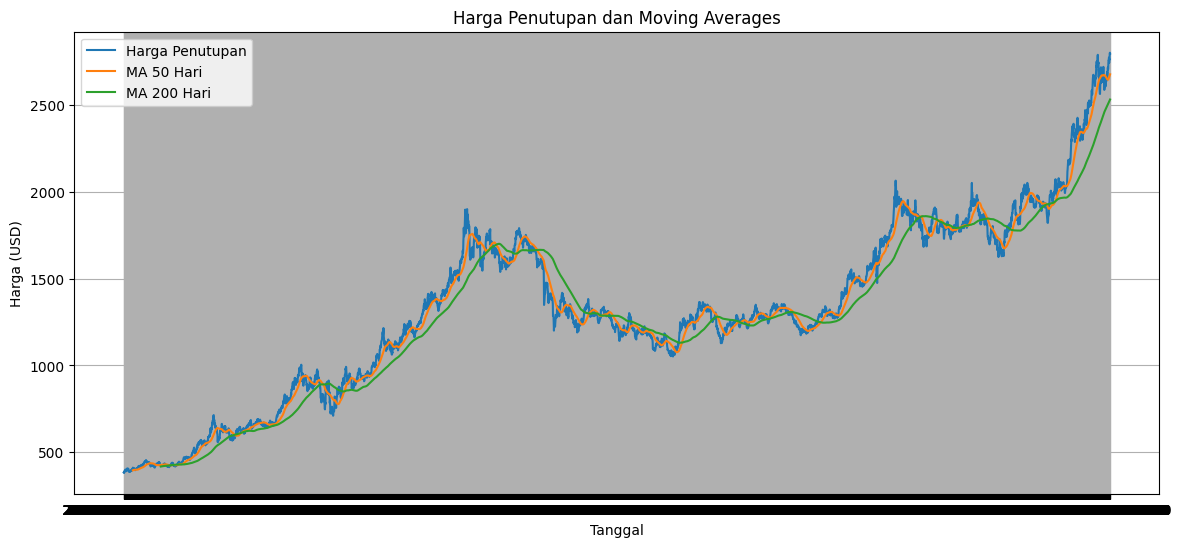

In [ ]:
# Menambahkan kolom MA 50 dan MA 200
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Harga Penutupan')
plt.plot(df['Date'], df['MA50'], label='MA 50 Hari')
plt.plot(df['Date'], df['MA200'], label='MA 200 Hari')
plt.title('Harga Penutupan dan Moving Averages')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True)
plt.show()

Dari hasil heatmap korelasi, terlihat bahwa fitur 'Open', 'High', 'Low', dan 'Close' sangat berkorelasi kuat satu sama lain (nilai korelasi 1), sedangkan 'Volume' memiliki korelasi sedang (~0.6) terhadap harga. Informasi ini penting untuk memilih fitur yang efektif dan menghindari redundansi dalam pengembangan model prediksi harga emas.

Dibutuhkan untuk melihat kolerasi antar fitur dikarenakan :
1. Menentukan fitur mana yang penting untuk model prediksi.

2. Menghindari multikolinearitas (fitur yang terlalu mirip bisa memperburuk model).

3. Misalnya, karena 'Open', 'High', 'Low', 'Close' sangat mirip, mungkin cukup memilih satu atau merangkum mereka untuk membuat model lebih efisien.

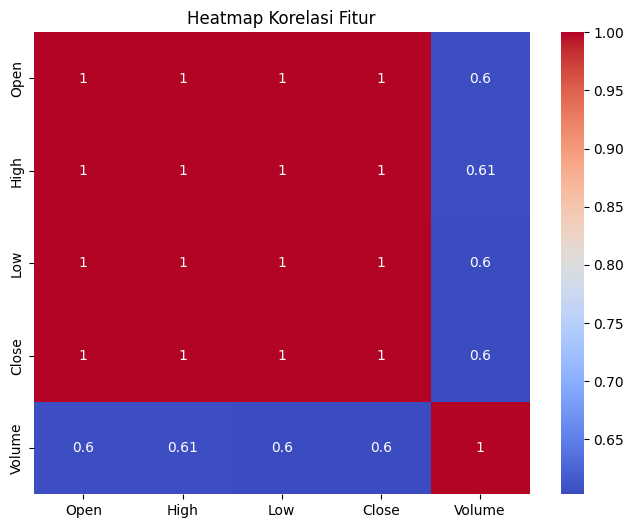

In [ ]:
# Menghitung korelasi
corr = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur')
plt.show()

Membuat histogram dari nilai perubahan harga harian.

Berdasarkan distribusi perubahan harga harian, mayoritas perubahan harga emas berada di sekitar 0 USD, menunjukkan bahwa harga emas relatif stabil. Meskipun demikian, terdapat perubahan besar dalam beberapa kasus, menandakan adanya volatilitas pada waktu-waktu tertentu. Distribusi ini menyerupai distribusi normal, yang menjadi pertimbangan penting dalam pemilihan model prediksi.

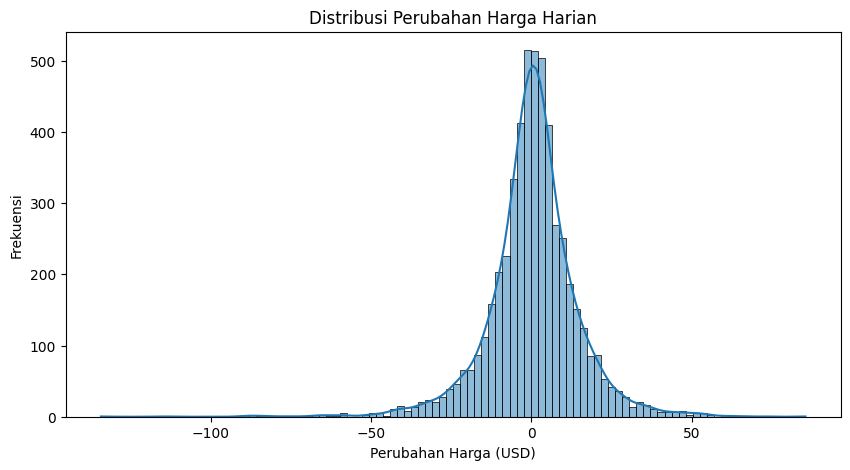

In [ ]:
# Menghitung perubahan harian
df['Daily Change'] = df['Close'].diff()

# Plot distribusi
plt.figure(figsize=(10, 5))
sns.histplot(df['Daily Change'].dropna(), bins=100, kde=True)
plt.title('Distribusi Perubahan Harga Harian')
plt.xlabel('Perubahan Harga (USD)')
plt.ylabel('Frekuensi')
plt.show()

Membuat candlestick chart berdasarkan data:

* x → tanggal

* open → harga pembukaan

* high → harga tertinggi

* low → harga terendah

* close → harga penutupan.

Candlestick chart memberikan visualisasi lengkap tentang pergerakan harga emas dari tahun ke tahun. Terlihat adanya tren kenaikan harga emas dalam jangka panjang, meskipun diiringi fluktuasi harga harian yang cukup signifikan pada periode-periode tertentu. Visualisasi ini membantu dalam memahami pola volatilitas serta dinamika harga emas dari waktu ke waktu.


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(title='Candlestick Chart Harga Emas',
                  xaxis_title='Tanggal',
                  yaxis_title='Harga (USD)')
fig.show()

4. Normalisasi dan data preparation

* Dilakukan Interpolasi linear pada beberapa fitur ['Close', 'Open', 'High', 'Low'] untuk menangani outlier, interpolasi linear baik untuk model time series terutama jika akan dilakukan dengan Modelling LSTM.

In [ ]:
df_interpolated = df.copy()

# Kolom yang mau dicek
columns = ['Close', 'Open', 'High', 'Low']

# Menghitung IQR untuk setiap kolom
Q1 = df_interpolated[columns].quantile(0.25)
Q3 = df_interpolated[columns].quantile(0.75)
IQR = Q3 - Q1

# Batas bawah dan atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menemukan outlier
outliers = pd.DataFrame()

for col in columns:
    outlier_mask = (df_interpolated[col] < lower_bound[col]) | (df_interpolated[col] > upper_bound[col])
    df_interpolated.loc[outlier_mask, col] = np.nan  # Set outlier jadi NaN

# Interpolasi semua NaN
df_interpolated = df_interpolated.interpolate(method='linear')

# Hapus duplikat kalau ada (karena satu baris bisa outlier di lebih dari satu kolom)
outliers = outliers.drop_duplicates()

print("Outliers detected:")
print(outliers)

Outliers detected:
Empty DataFrame
Columns: []
Index: []


<ipython-input-6-a6aa2d180c29>:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df_interpolated.interpolate(method='linear')


* Pengecekan ulang Outlier untuk memastikan tidak ada Outlier lagi pada data yang akan digunakan.

Pada tahap data preparation, ditemukan outlier pada kolom Volume, namun karena kolom ini tidak digunakan dalam proses modeling dan lonjakan volume merupakan kejadian alami di pasar, maka outlier pada Volume dibiarkan tanpa penghapusan atau interpolasi. Fokus penanganan outlier hanya dilakukan pada fitur yang digunakan untuk modeling.



In [ ]:
print("Mendeteksi Outlier:")
def detect_outliers(df_interpolated):
    outlier_info = {}
    for col in df_interpolated.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df_interpolated[col].quantile(0.25)
        Q3 = df_interpolated[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_interpolated[(df_interpolated[col] < lower_bound) | (df_interpolated[col] > upper_bound)]
        outlier_info[col] = outliers.shape[0]
    return outlier_info

outliers = detect_outliers(df_interpolated)
for col, count in outliers.items():
    print(f"Kolom '{col}': {count} outlier")
print()

Mendeteksi Outlier:
Kolom 'Open': 0 outlier
Kolom 'High': 0 outlier
Kolom 'Low': 0 outlier
Kolom 'Close': 0 outlier
Kolom 'Volume': 82 outlier



Kolom `Date` dikonversi ke format datetime (`pd.to_datetime`) untuk memastikan data dapat diolah secara kronologis dan memungkinkan pemanfaatan fungsi-fungsi time series Pandas.

In [ ]:
df_interpolated['Date'] = pd.to_datetime(df_interpolated['Date'])

# Pastikan data sudah terurut berdasarkan tanggal
df_interpolated = df_interpolated.sort_values('Date').reset_index(drop=True)

tahap scaling dan windowing (sequence preparation) untuk time series prediction.

Model berbasis neural network (seperti LSTM/GRU) sensitif terhadap skala data. Jika skala tidak diseragamkan, model bisa sulit belajar, lambat konvergen, atau malah tidak stabil.



In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_interpolated[['Open', 'High', 'Low', 'Close']])
scaled_df = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close'])
scaled_df['Date'] = df_interpolated['Date'].values

Model time series seperti LSTM memerlukan data berbentuk urutan (sequence) agar bisa memahami pola perubahan harga dari waktu ke waktu. sehingga disini dibuat  data sequence sepanjang 60 hari untuk memprediksi harga Close di hari ke-61.

In [ ]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 3])  # target: 'Close'
    return np.array(X), np.array(y)

Menyesuaikan dimensi data untuk LSTM: (samples, time_steps, features).

In [ ]:
time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 4)  # 4 fitur: Open, High, Low, Close

Fungsi: Membagi data menjadi:

70% untuk Training (belajar)

20% untuk Validation (tuning)

10% untuk Testing (evaluasi akhir)

ini dilakukan untuk agar model bisa belajar, diuji, dan divalidasi dengan data yang berbeda-beda, sehingga mengurangi risiko overfitting.

In [ ]:
# Split data
total_samples = len(X)
train_end = int(0.7 * total_samples)
val_end = int(0.9 * total_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

5. Modelling LSTM dengan 4 Fitur.

Early Stopping digunakan untuk menghentikan training lebih awal jika model sudah tidak membaik lagi (berdasarkan val_loss).

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Penjelasan Layer:

* LSTM(64, return_sequences=True, activation='relu'):
Layer LSTM pertama dengan 64 unit.

* return_sequences=True supaya outputnya masih berbentuk urutan (sequence), dibutuhkan untuk diteruskan ke LSTM berikutnya.

* Aktivasi relu dipilih untuk mempercepat konvergensi dan menghindari vanishing gradient.

* Dropout(0.2):
Membantu mengurangi overfitting dengan menghapus (drop) 20% neuron secara acak saat training.

* LSTM(32, activation='relu'):
Layer LSTM kedua dengan 32 unit.

* Di sini return_sequences=False (default), artinya outputnya satu vektor, bukan urutan lagi, untuk disambungkan ke Dense layer.

* Dropout(0.2):
Lagi-lagi untuk regularisasi.

* Dense(1):
Layer output dengan 1 neuron karena kita mau memprediksi satu nilai kontinu: harga Close.

* compile(optimizer='adam', loss='mse'):

* Optimizer Adam dipakai karena cepat dan efisien.

* Loss function MSE (Mean Squared Error) cocok untuk masalah regresi harga.

In [ ]:
# Buat model LSTM
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(time_step, 4)),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

Training dilakukan dengan kontrol overfitting menggunakan EarlyStopping. Setelah model selesai dilatih, prediksi 2 hari ke depan dilakukan dengan pendekatan auto-regressive, di mana prediksi hari pertama digunakan untuk prediksi hari kedua, dan hasil prediksi di-inverse ke nilai harga asli agar bisa dianalisis.

Penjelasan Training model:

* model.fit() digunakan untuk melatih model menggunakan data training (X_train, y_train).

* epochs=50: Model akan maksimal dilatih selama 50 epoch. Tapi dengan EarlyStopping, training bisa selesai lebih cepat kalau tidak ada perbaikan.

* validation_data=(X_val, y_val): Setiap epoch, model juga diuji di data validasi untuk memantau overfitting.

* batch_size=32: Data dilatih dalam mini-batch sebanyak 32 contoh sekaligus, untuk mempercepat dan menstabilkan training.

* verbose=1: Menampilkan progress training secara rinci di layar.

* callbacks=[early_stop]: Memasukkan EarlyStopping untuk menghentikan training lebih awal jika perlu.

In [ ]:
# Training
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 0.0015 - val_loss: 2.9055e-04
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0014 - val_loss: 8.4979e-04
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0011 - val_loss: 2.7578e-04
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - loss: 0.0011 - val_loss: 2.9283e-04
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0011 - val_loss: 7.1165e-04
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 9.7875e-04 - val_loss: 3.9992e-04
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 9.2571e-04 - val_loss: 2.2335e-04
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 8.0438e-04 - val_loss: 4.0667e-04
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 7.6023e-04 - val_lo

Ambil data window terakhir dari data test (X_test[-1]), karena kita mau memprediksi harga setelah data terakhir.

Data di-reshape menjadi format [1, 60, 4] untuk disuapkan ke model.



In [ ]:
# Prediksi 2 hari ke depan (dari akhir X_test)
input_data = X_test[-1].reshape(1, time_step, 4)
predictions_scaled = []

Lakukan prediksi sebanyak 2 kali (untuk hari ke-1 dan hari ke-2).

Setelah dapat prediksi pred, masukkan ke predictions_scaled.

Update window input:

Hapus data paling awal (hari pertama dalam window).

Tambahkan prediksi baru ke ujung window.

Pada input baru ini, hanya kolom Close yang diisi dengan prediksi (pred), sementara Open, High, Low diisi dummy 0.

In [ ]:
for _ in range(2):
    pred = model.predict(input_data)[0][0]
    predictions_scaled.append(pred)

    # Tambahkan prediksi ke window (hanya isi kolom 'Close', lainnya dummy = 0)
    new_row = np.array([[0, 0, 0, pred]])
    input_data = np.append(input_data[:, 1:, :], new_row.reshape(1, 1, 4), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Karena saat scaling awal semua fitur (Open, High, Low, Close) digunakan, sekarang saat inverse transform juga harus membentuk array 4 kolom.

Kolom Open, High, Low diisi dengan 0 dummy.

Close diisi dengan hasil prediksi.

Setelah itu lakukan inverse_transform untuk mengubah data dari skala 0-1 kembali ke nilai USD asli.

In [ ]:
# Inverse transform hasil prediksi
dummy = np.zeros((2, 3))  # Open, High, Low dummy
full = np.concatenate([dummy, np.array(predictions_scaled).reshape(-1, 1)], axis=1)
pred_close_usd = scaler.inverse_transform(full)[:, 3]

# Tampilkan hasil
print("Prediksi harga emas (USD/oz):")
print(f"Hari ke-1 (besok): ${pred_close_usd[0]:.2f}")
print(f"Hari ke-2 (lusa) : ${pred_close_usd[1]:.2f}")

Prediksi harga emas (USD/oz):
Hari ke-1 (besok): $2760.13
Hari ke-2 (lusa) : $2582.62


6. Evaluasi Model LSTM

Pada tahap evaluasi, prediksi hasil model yang telah di-standardisasi dikembalikan ke skala aslinya untuk memperoleh nilai error dalam satuan yang bermakna (USD). Evaluasi menggunakan MAE, RMSE, dan R² memberikan gambaran akurat tentang performa model dalam memprediksi harga emas, membantu dalam menilai keakuratan dan reliabilitas prediksi untuk data baru.

Menghitung tiga metrik evaluasi:

* MAE (Mean Absolute Error): Rata-rata kesalahan absolut prediksi vs aktual.

* RMSE (Root Mean Squared Error): Penalti lebih besar untuk prediksi yang sangat meleset.

* R² Score: Seberapa baik model menjelaskan variabilitas data aktual (semakin mendekati 1, semakin bagus).

In [ ]:
y_pred = model.predict(X_test)

# Invers transform
# Misalnya hanya 'Close' yang dinormalisasi:
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
y_test_inv = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = close_scaler.inverse_transform(y_pred)

# Hitung metrik
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print("Evaluasi Model pada Data Test:")
print(f"MAE  : {mae:.2f} USD")
print(f"RMSE : {rmse:.2f} USD")
print(f"R² Score : {r2:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Evaluasi Model pada Data Test:
MAE  : 29.75 USD
RMSE : 39.14 USD
R² Score : 0.9821


7. Model GRU dengan menggunakan 4 fitur berikut Evaluasinya.

Membangun model GRU (Gated Recurrent Unit) dengan dua lapisan:

* GRU pertama (return_sequences=True) mengoutputkan urutan ke GRU berikutnya.

* GRU kedua mengoutput satu nilai akhir (tidak pakai return_sequences).

* Diakhiri Dense layer untuk prediksi satu nilai Close price.

Model dikompilasi dengan:

* Optimizer: Adam — karena adaptif dan biasanya cepat konvergen.

* Loss function: MSE (Mean Squared Error) — karena target kita berupa nilai * numerik kontinu (regresi).

Hasil prediksi masih dalam skala MinMaxScaler (0–1), sehingga:

* Menyisipkan dummy 0 untuk kolom Open, High, dan Low.

* Menggabungkan ke array 4 kolom agar bisa di-inverse_transform.

* Mengambil hasil inverse hanya pada kolom Close.

In [ ]:
# GRU Model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(time_step, 4)))
model.add(GRU(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])

# Evaluation
predicted = model.predict(X_test)
predicted_unscaled = scaler.inverse_transform(np.concatenate([
    np.zeros((predicted.shape[0], 3)),  # dummy for Open, High, Low
    predicted
], axis=1))[:, -1]  # ambil hanya kolom 'Close'

y_test_unscaled = scaler.inverse_transform(np.concatenate([
    np.zeros((y_test.shape[0], 3)),
    y_test.reshape(-1, 1)
], axis=1))[:, -1]

mae = mean_absolute_error(y_test_unscaled, predicted_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predicted_unscaled))
r2 = r2_score(y_test_unscaled, predicted_unscaled)

print("\nEvaluasi Model GRU:")
print(f"MAE  : {mae:.2f} USD")
print(f"RMSE : {rmse:.2f} USD")
print(f"R²   : {r2:.4f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - loss: 0.0098 - val_loss: 1.6021e-04
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 7.2685e-05 - val_loss: 9.5228e-05
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 5.8923e-05 - val_loss: 9.4699e-05
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 5.7760e-05 - val_loss: 1.0119e-04
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 4.8208e-05 - val_loss: 7.9814e-05
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 4.4894e-05 - val_loss: 8.3905e-05
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 4.5261e-05 - val_loss: 6.4948e-05
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 4.1889e-05 - val_loss: 6.6267e-05
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - loss: 4.1966e-05 - val_loss: 6.1700e-05
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 4.4590e-05 - val_loss: 6.3208e-05
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step -

9. Data preparation untuk GRU model ke 2

Disini dilakukan preparation dengan mengambil Fitur 'Close' saja untuk model GRU sebagai perbandingan mana yang lebih tepat dan cepat.
fitur diambil dan membuat dataset baru dan dilakukan Spliting Train, val dan test.

In [ ]:
close_data = scaled_data[:, 3]

In [ ]:
def create_dataset(close_data, time_step=60):
    X, y = [], []
    for i in range(len(close_data) - time_step - 1):
        X.append(close_data[i:(i + time_step)])
        y.append(close_data[i + time_step])
    return np.array(X), np.array(y)

In [ ]:
time_step = 60
X, y = create_dataset(close_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
total_samples = len(X)
train_end = int(0.7 * total_samples)
val_end = int(0.9 * total_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

10. Modelling GRU dengan menggunakan 1 fitur 'Close' berikut dengan evaluasinya.

Model sama spesifikasi seperti model GRU sebelumnya, yang berubah hanya jumlah fitur yang digunakan.

In [ ]:
# GRU Model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])

# Evaluation
predicted = model.predict(X_test)
predicted_unscaled = scaler.inverse_transform(np.concatenate([
    np.zeros((predicted.shape[0], 3)),  # dummy for Open, High, Low
    predicted
], axis=1))[:, -1]  # ambil hanya kolom 'Close'

y_test_unscaled = scaler.inverse_transform(np.concatenate([
    np.zeros((y_test.shape[0], 3)),
    y_test.reshape(-1, 1)
], axis=1))[:, -1]

mae = mean_absolute_error(y_test_unscaled, predicted_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predicted_unscaled))
r2 = r2_score(y_test_unscaled, predicted_unscaled)

print("\nEvaluasi Model GRU:")
print(f"MAE  : {mae:.2f} USD")
print(f"RMSE : {rmse:.2f} USD")
print(f"R²   : {r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 0.0115 - val_loss: 1.2864e-04
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - loss: 6.0459e-05 - val_loss: 9.4105e-05
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 6.0463e-05 - val_loss: 9.7026e-05
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 5.2839e-05 - val_loss: 7.8189e-05
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 5.6592e-05 - val_loss: 7.7987e-05
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 5.0147e-05 - val_loss: 7.0614e-05
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 4.3461e-05 - val_loss: 8.2672e-05
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 4.0602e-05 - val_loss: 6.7790e-05
Epoch 9/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 5.0577e-05 - val_loss: 6.2547e-05
Epoch 10/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 4.2982e-05 - val_loss: 5.8523e-05
Epoch 11/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s

11. Prediksi Harga Emas untuk 2 hari kedepan.

* close_data[-60:]: Mengambil 60 hari terakhir dari data harga emas (Close) yang telah dinormalisasi (scaled).

* .reshape(1, 60, 1): Mengubah bentuk array agar sesuai dengan input GRU (batch_size, time_step, features).

* model.predict(last_60): Memprediksi harga untuk hari ke-1 (besok).

* Untuk hari ke-2 (lusa), prediksi hari ke-1 disisipkan ke dalam data urutan:

* np.append(close_data[-59:], pred_1): Menggeser window satu hari ke depan dan tambahkan hasil prediksi.

* Dilakukan prediksi kembali untuk menghasilkan harga hari ke-2.

In [ ]:
# Prediksi Next 2 Hari
last_60 = close_data[-60:].reshape(1, 60, 1)
pred_1 = model.predict(last_60)
extended = np.append(close_data[-59:], pred_1).reshape(1, 60, 1)
pred_2 = model.predict(extended)

# Inverse transform ke nilai harga asli
pred_1_real = scaler.inverse_transform(np.concatenate([np.zeros((1, 3)), pred_1], axis=1))[0, -1]
pred_2_real = scaler.inverse_transform(np.concatenate([np.zeros((1, 3)), pred_2], axis=1))[0, -1]

print("\nPrediksi Harga Emas (USD/oz):")
print(f"Hari ke-1 (besok): ${pred_1_real:.2f}")
print(f"Hari ke-2 (lusa) : ${pred_2_real:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Prediksi Harga Emas (USD/oz):
Hari ke-1 (besok): $2773.94
Hari ke-2 (lusa) : $2754.58


12. Visualisasi dari Data prediksi dan Val loss.

Interpretasi Plot
* Garis biru (Actual) menunjukkan pergerakan harga emas sebenarnya.

* Garis oranye (Predicted - GRU) menunjukkan hasil prediksi dari model.

* Kedua garis tampak sangat berdekatan dan mengikuti pola yang sama, yang mengindikasikan bahwa model GRU mampu:

 * Menangkap pola historis dengan baik,

 * Memberikan prediksi yang cukup akurat pada data uji.



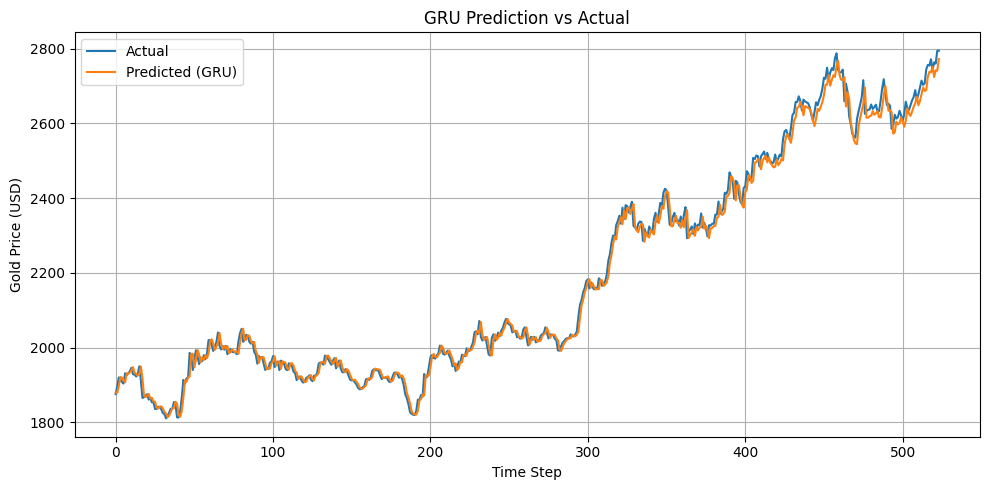

In [ ]:
# Plot Prediksi vs Aktual
plt.figure(figsize=(10, 5))
plt.plot(y_test_unscaled, label='Actual')
plt.plot(predicted_unscaled, label='Predicted (GRU)')
plt.title('GRU Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Interpretasi Plot
* Train Loss dan Validation Loss cepat turun di awal, lalu stabil dengan nilai sangat kecil.

* Kedua garis sangat berdekatan, menunjukkan bahwa:

 * Model belajar dengan sangat baik pada data latih.

 * Tidak terjadi overfitting (karena val_loss tidak naik tajam).

* Nilai loss mendekati nol mengindikasikan bahwa model menghasilkan prediksi yang sangat akurat terhadap kedua jenis data.



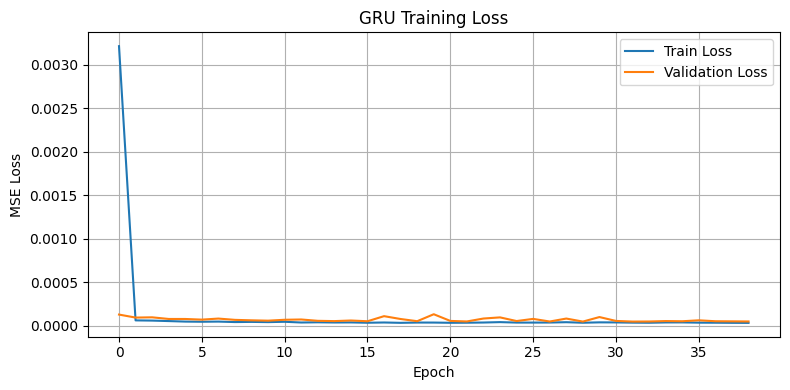

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()